In [1]:
import json
import functools
import multiprocessing
from pathlib import Path

import numpy as np
import numpy.linalg
import pandas as pd
import scipy as sp
import scipy.optimize
from matplotlib import pyplot as plt

from helper import get_station_data, get_train_test_time_ranges

In [2]:
province='AB'
#province='BC'
# province='MB'
#province='NB'
#province='NL'
#province='NS'
#province='NT'
#province='NU'
# province='ON'
#province='PE'
#province='QC'
#province='SK'
#province='YT'

# station_id_set = set(['6158355', '6158359'])
station_id_set = set(['3034479', '3034485'])

In [3]:
raw_data_base_dir = Path('raw-data')

In [4]:
df = get_station_data(
    raw_data_base_dir / province,
    station_id_set=station_id_set,
)

In [5]:
len(df)

311253

In [6]:
group = df.groupby('Climate ID')
display(group.count().rsub(group.size(), axis=0))

,Longitude (x),Latitude (y),Station Name,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h)
Climate ID,,,,,,,,,,
3034479,0,0,0,0,0,0,0,0,9405,1289
3034485,0,0,0,0,0,0,0,0,9609,915


In [15]:
df['Station Name'].unique()

array(['MEDICINE HAT RCS', 'MEDICINE HAT'], dtype=object)

In [7]:
df

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Wind Dir (10s deg),Wind Spd (km/h)
0,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 15:00:00,2001,1,12,15:00,2.0,13.0
1,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 16:00:00,2001,1,12,16:00,1.0,11.0
2,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 17:00:00,2001,1,12,17:00,2.0,9.0
3,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 18:00:00,2001,1,12,18:00,2.0,9.0
4,-110.72,50.03,MEDICINE HAT RCS,3034485,2001-01-12 19:00:00,2001,1,12,19:00,3.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
311248,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 21:00:00,2023,8,18,21:00,34.0,19.0
311249,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 22:00:00,2023,8,18,22:00,29.0,18.0
311250,-110.72,50.03,MEDICINE HAT RCS,3034485,2023-08-18 22:00:00,2023,8,18,22:00,31.0,15.0
311251,-110.72,50.02,MEDICINE HAT,3034479,2023-08-18 23:00:00,2023,8,18,23:00,29.0,26.0


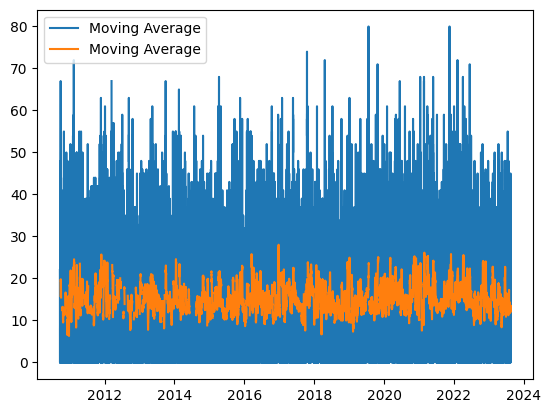

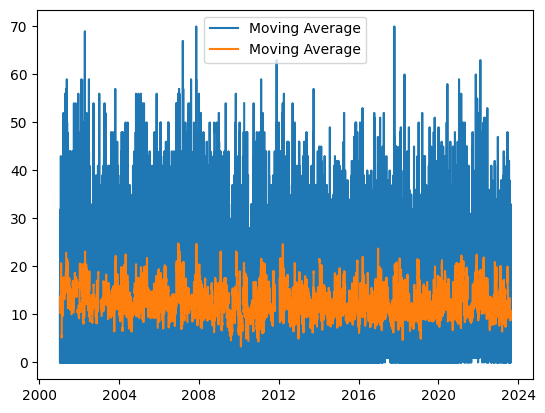

In [8]:
roll_window = 24*7

for index, sub_df in df.groupby('Climate ID'):
    fig, ax = plt.subplots()
    ax.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd (km/h)'],
        label='Moving Average',
    )
    ax.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Spd (km/h)'].rolling(roll_window).mean(),
        label='Moving Average',
    )
    ax.legend()
plt.show()

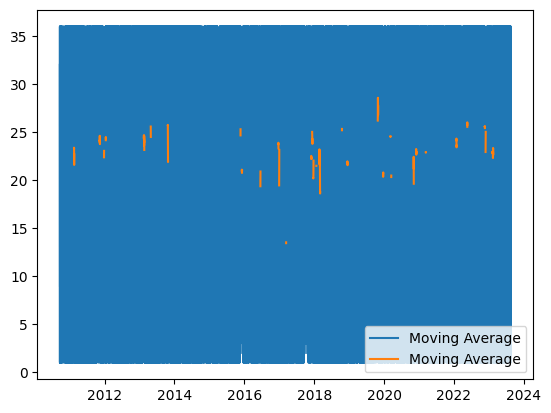

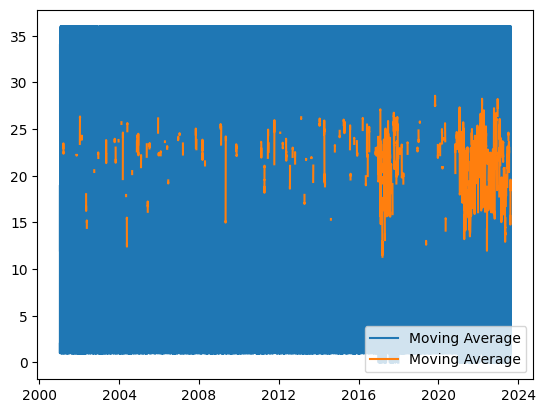

In [9]:
roll_window = 24*7

for index, sub_df in df.groupby('Climate ID'):
    fig, ax = plt.subplots()
    ax.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Dir (10s deg)'],
        label='Moving Average',
    )
    ax.plot(
        sub_df['Date/Time (LST)'],
        sub_df['Wind Dir (10s deg)'].rolling(roll_window).mean(),
        label='Moving Average',
    )
    ax.legend()
plt.show()

In [10]:
ts_dfs = []
for index, sub_df in df.groupby(by='Climate ID'):
    ts_df = sub_df[['Date/Time (LST)', 'Wind Spd (km/h)', 'Wind Dir (10s deg)']]
    ts_df = (
        ts_df
        .set_index('Date/Time (LST)')
        .rename(
            columns={
                colname: f'{index} - {colname}'
                for colname in ts_df.columns
            },
        )
    )
    ts_dfs.append(ts_df)

ts_df = pd.concat(ts_dfs, ignore_index=False, axis='columns')
display(ts_df)

,3034479 - Wind Spd (km/h),3034479 - Wind Dir (10s deg),3034485 - Wind Spd (km/h),3034485 - Wind Dir (10s deg)
Date/Time (LST),,,,
2001-01-12 15:00:00,NaN,NaN,13.0,2.0
2001-01-12 16:00:00,NaN,NaN,11.0,1.0
2001-01-12 17:00:00,NaN,NaN,9.0,2.0
2001-01-12 18:00:00,NaN,NaN,9.0,2.0
2001-01-12 19:00:00,NaN,NaN,11.0,3.0
...,...,...,...,...
2023-08-18 19:00:00,41.0,34.0,22.0,35.0
2023-08-18 20:00:00,30.0,33.0,21.0,34.0
2023-08-18 21:00:00,39.0,34.0,19.0,34.0


In [11]:
def score_vec(item, matrix):
    try:
        (curr_idx, curr_row), (next_idx, next_row) = item
    except:
        return

    if curr_row.isna().any() or next_row.isna().any():
        return None
    
    x_curr = curr_row.iloc[[0,2]]
    x_next = next_row.iloc[[0,2]]

    x_pred = matrix @ x_curr

    delta = x_next - x_pred

    return np.linalg.norm(delta)**2

def objective_func(xx, train_df, num_workers=None):
    num_elements = xx.size
    side = int(np.sqrt(num_elements))
    matrix = xx.reshape(side,side)
    
    iterators = [
        train_df.iterrows(),
        train_df.iterrows(),
    ]
    
    # move the second one forward
    next(iterators[1])

    score = 0
    with multiprocessing.Pool(processes=num_workers) as pool:
        for result in pool.imap_unordered(
            func=functools.partial(
                score_vec,
                matrix=matrix,
            ),
            iterable=zip(*iterators),
            chunksize=256,
        ):
            if result is None:
                continue

            score += result

    return score

In [12]:
results = []
for idx,(train_range, test_range) in enumerate(get_train_test_time_ranges()):
    train_start, train_end = train_range

    train_mask = ts_df.index.map(lambda time_idx: time_idx >= train_start and time_idx <= train_end)

    train_df = ts_df[train_mask]
    test_mask = ts_df[~train_mask]

    display(train_df.count().rsub(train_df.size, axis=0))

    result = sp.optimize.minimize(
        fun=functools.partial(
            objective_func,
            train_df=train_df,
            num_workers=4,
        ),
        x0=np.eye(2).flatten() if len(results) == 0 else results[-1].x,
    )
    print(result)
    results.append(result)

    with open(f'time-series-with-magnitude-{idx}.json', 'w') as flink:
        json.dump(list(result.x), flink)

3034479 - Wind Spd (km/h)       52721
3034479 - Wind Dir (10s deg)    53962
3034485 - Wind Spd (km/h)       52650
3034485 - Wind Dir (10s deg)    53028
dtype: int64

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 705559.423789907
        x: [ 6.066e-01  4.315e-01  1.808e-01  7.476e-01]
      nit: 13
      jac: [ 3.047e-01  3.438e-01  7.812e-02  1.719e-01]
 hess_inv: [[ 2.813e-07 -6.148e-07  4.061e-07 -4.735e-07]
            [-6.148e-07  1.358e-06 -8.938e-07  1.086e-06]
            [ 4.061e-07 -8.938e-07  5.890e-07 -7.051e-07]
            [-4.735e-07  1.086e-06 -7.051e-07  9.797e-07]]
     nfev: 202
     njev: 38


3034479 - Wind Spd (km/h)       105453
3034479 - Wind Dir (10s deg)    108050
3034485 - Wind Spd (km/h)       105229
3034485 - Wind Dir (10s deg)    106470
dtype: int64

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1377510.4205108583
        x: [ 6.255e-01  4.090e-01  1.482e-01  7.855e-01]
      nit: 11
      jac: [ 1.688e+00  1.844e+00  9.219e-01  1.641e+00]
 hess_inv: [[ 7.937e-07 -6.699e-07 -2.679e-07  6.272e-07]
            [-6.699e-07  5.894e-07  2.096e-07 -5.205e-07]
            [-2.679e-07  2.096e-07  1.028e-07 -2.204e-07]
            [ 6.272e-07 -5.205e-07 -2.204e-07  5.073e-07]]
     nfev: 202
     njev: 38


In [29]:
def compare_forecast(xx, test_df, max_iter=100):
    num_elements = xx.size
    side = int(np.sqrt(num_elements))
    matrix = xx.reshape(side,side)

    start_vec = test_df.iloc[0, [0,2]]

    vec = start_vec
    predict_vecs = [
        vec := matrix @ vec
        for _ in range(max_iter)
    ]
    predict_df = pd.DataFrame(
        columns=test_df.columns[[0,2]],
        index=test_df.index.to_numpy()[:max_iter],
        data=predict_vecs
    )

    return predict_df


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 705559.423789907
        x: [ 6.066e-01  4.315e-01  1.808e-01  7.476e-01]
      nit: 13
      jac: [ 3.047e-01  3.438e-01  7.812e-02  1.719e-01]
 hess_inv: [[ 2.813e-07 -6.148e-07  4.061e-07 -4.735e-07]
            [-6.148e-07  1.358e-06 -8.938e-07  1.086e-06]
            [ 4.061e-07 -8.938e-07  5.890e-07 -7.051e-07]
            [-4.735e-07  1.086e-06 -7.051e-07  9.797e-07]]
     nfev: 202
     njev: 38

train_rsm=6.34147248107763
test_score=1441318.3327380647
test_rms=6.411254748050891


3034479 - Wind Spd (km/h)    20.472145
3034485 - Wind Spd (km/h)    16.986024
dtype: float64

18.72908454132316

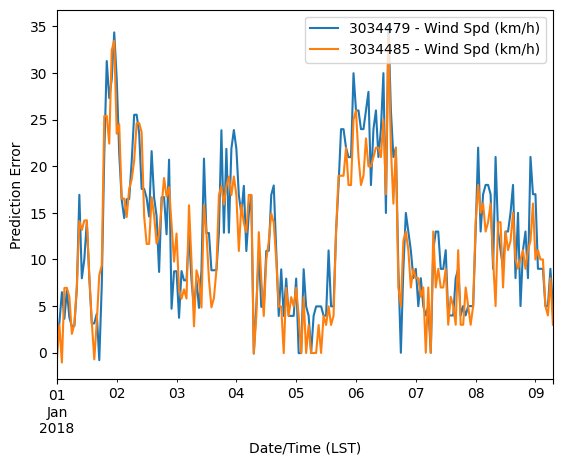

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1377510.4205108583
        x: [ 6.255e-01  4.090e-01  1.482e-01  7.855e-01]
      nit: 11
      jac: [ 1.688e+00  1.844e+00  9.219e-01  1.641e+00]
 hess_inv: [[ 7.937e-07 -6.699e-07 -2.679e-07  6.272e-07]
            [-6.699e-07  5.894e-07  2.096e-07 -5.205e-07]
            [-2.679e-07  2.096e-07  1.028e-07 -2.204e-07]
            [ 6.272e-07 -5.205e-07 -2.204e-07  5.073e-07]]
     nfev: 202
     njev: 38

train_rsm=6.267733536753719
test_score=768463.425098339
test_rms=6.618124225085874


3034479 - Wind Spd (km/h)    14.771458
3034485 - Wind Spd (km/h)    13.541422
dtype: float64

14.156440132347436

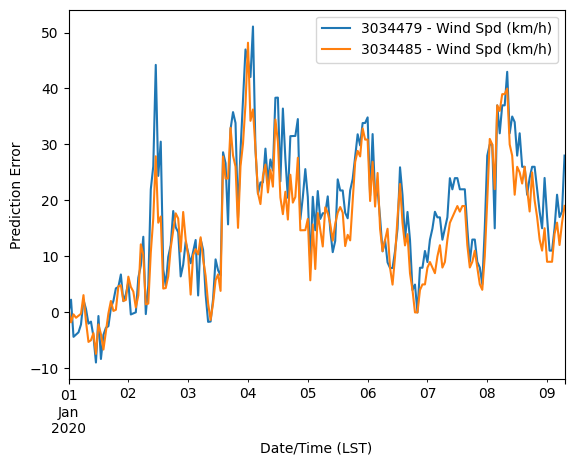

In [58]:
max_iter = 200
for (train_range, test_range), result in zip(get_train_test_time_ranges(),results):
    train_start, train_end = train_range
    test_start, test_end = test_range

    train_mask = ts_df.index.map(lambda time_idx: time_idx >= train_start and time_idx <= train_end)
    test_mask = ts_df.index.map(lambda time_idx: time_idx >= test_start and time_idx <= test_end)

    train_df = ts_df[train_mask]
    test_df = ts_df[test_mask]
    predict_df = compare_forecast(result.x, test_df, max_iter=200)

    test_score = objective_func(result.x, train_df=test_df)
    
    train_rsm = np.sqrt(result.fun / len(train_df))
    test_rms = np.sqrt(test_score/len(test_df))
    prediction_rms = (test_delta**2).mean(axis=0).pow(0.5)

    display(result)
    print(f'{train_rsm=}')
    print(f'{test_score=}')
    print(f'{test_rms=}')
    
    display(prediction_rms)
    display(prediction_rms.mean())

    fig, ax = plt.subplots()
    test_delta = test_df.iloc[:max_iter, [0,2]] - predict_df
    test_delta.plot(ax=ax)
    ax.set_ylabel('Prediction Error')
    
    plt.show()
    print()
